In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import pearsonr

# Set professional plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 7)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 12

# Define paths
RESULTS_DAILY = Path("../results")
RESULTS_LOB = Path("../results/lob")

# Define the models we tested
MODELS = ["sinusoidal", "time2vec", "ctlpe", "alibi", "learned"] 
# (Remove 'learned' if you didn't run it)

print("Libraries loaded. Ready for analysis.")

Libraries loaded. Ready for analysis.


In [15]:
def calculate_metrics(df, task_type="daily"):
    """
    Computes Quant/ML metrics for a given results dataframe.
    
    Args:
        df: DataFrame with 'actual' and 'predicted' columns.
        task_type: 'daily' (Volatility) or 'lob' (Returns).
    """
    # 1. Error Metrics
    mse = ((df['predicted'] - df['actual']) ** 2).mean()
    rmse = np.sqrt(mse)
    mae = (df['predicted'] - df['actual']).abs().mean()
    
    # 2. Information Coefficient (IC)
    # Pearson Correlation: Measures how well the model predicts the *relative* moves
    ic, _ = pearsonr(df['predicted'], df['actual'])
    
    # 3. Directional Accuracy (DA)
    if task_type == "lob":
        # For LOB, target is Log Return. Sign = Direction.
        # Accuracy: Did we get the sign right?
        same_sign = np.sign(df['predicted']) == np.sign(df['actual'])
        da = same_sign.mean()
    else:
        # For Daily Volatility, target is a positive float. 
        # Without previous day's vol in the CSV, DA is hard to compute strictly.
        # We rely on IC as the directional proxy.
        da = np.nan 

    return {
        "RMSE": rmse,
        "MAE": mae,
        "IC": ic,
        "Dir. Acc": da
    }

def load_results(models, base_path, prefix, task_type):
    metrics = []
    data_dict = {}
    
    for m in models:
        # Handle filenames like 'wfv_sinusoidal.csv' or 'lob_sinusoidal.csv'
        filename = f"{prefix}_{m}.csv"
        path = base_path / filename
        
        if not path.exists():
            print(f"⚠️ Warning: {filename} not found. Skipping.")
            continue
            
        df = pd.read_csv(path)
        data_dict[m] = df
        
        met = calculate_metrics(df, task_type)
        met["Model"] = m
        metrics.append(met)
        
    return pd.DataFrame(metrics).set_index("Model"), data_dict

In [16]:
# Load Daily Results
daily_metrics, daily_data = load_results(
    MODELS, 
    RESULTS_DAILY, 
    prefix="wfv", 
    task_type="daily"
)

print("=== PART 1: DAILY VOLATILITY RESULTS ===")
# Sort by IC (Higher is better) or RMSE (Lower is better)
display(daily_metrics.sort_values("RMSE").style.background_gradient(cmap="viridis_r", subset=["RMSE", "MAE"]))
display(daily_metrics.sort_values("IC", ascending=False).style.background_gradient(cmap="viridis", subset=["IC"]))

⚠️ Warning: wfv_learned.csv not found. Skipping.
=== PART 1: DAILY VOLATILITY RESULTS ===


,RMSE,MAE,IC,Dir. Acc
Model,,,,
alibi,0.008531,0.006864,0.898660,nan
sinusoidal,0.011521,0.008995,0.809906,nan
ctlpe,0.012481,0.009509,0.776977,nan
time2vec,0.013430,0.009745,0.735631,nan


,RMSE,MAE,IC,Dir. Acc
Model,,,,
alibi,0.008531,0.006864,0.898660,nan
sinusoidal,0.011521,0.008995,0.809906,nan
ctlpe,0.012481,0.009509,0.776977,nan
time2vec,0.013430,0.009745,0.735631,nan


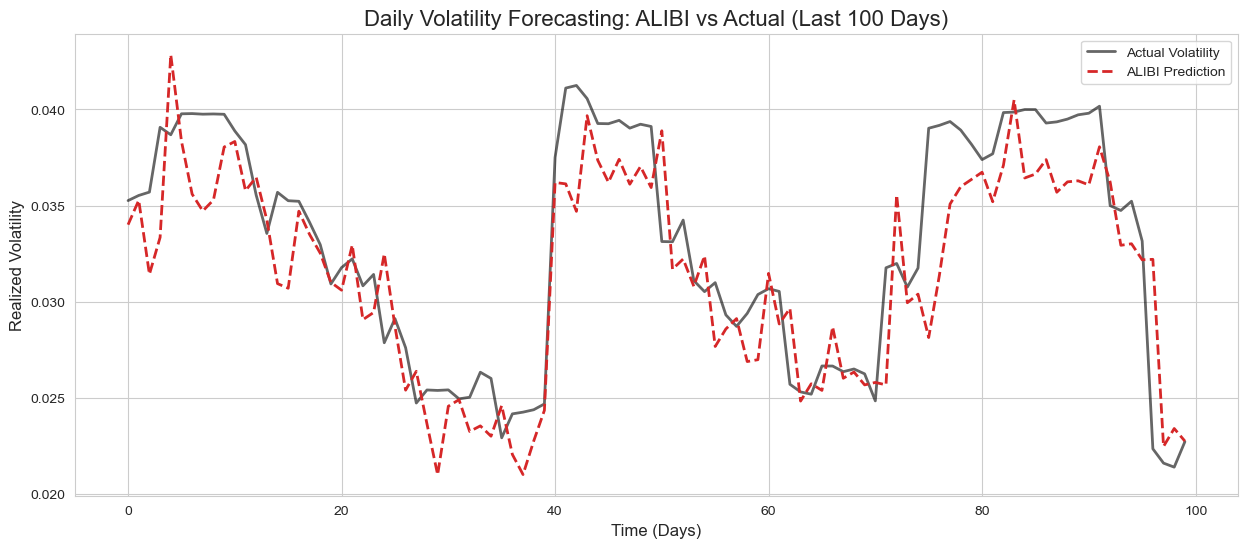

In [17]:
# Plot Forecast vs Actual (Last 100 days to see detail)
target_model = "alibi" # Change this to your winner
if target_model in daily_data:
    df = daily_data[target_model].iloc[-100:] 
    
    plt.figure(figsize=(15, 6))
    plt.plot(df['actual'].values, label='Actual Volatility', color='black', alpha=0.6, linewidth=2)
    plt.plot(df['predicted'].values, label=f'{target_model.upper()} Prediction', color='#d62728', linestyle='--', linewidth=2)
    
    plt.title(f"Daily Volatility Forecasting: {target_model.upper()} vs Actual (Last 100 Days)", fontsize=16)
    plt.ylabel("Realized Volatility")
    plt.xlabel("Time (Days)")
    plt.legend()
    plt.show()

In [18]:
# Load LOB Results
lob_metrics, lob_data = load_results(
    MODELS, 
    RESULTS_LOB, 
    prefix="lob", 
    task_type="lob"
)

print("=== PART 2: HIGH-FREQUENCY LOB RESULTS ===")
# For LOB, Directional Accuracy is often more important than RMSE
display(lob_metrics.sort_values("Dir. Acc", ascending=False).style.background_gradient(cmap="viridis", subset=["Dir. Acc"]))
display(lob_metrics.sort_values("RMSE").style.background_gradient(cmap="viridis_r", subset=["RMSE"]))

⚠️ Warning: lob_learned.csv not found. Skipping.
=== PART 2: HIGH-FREQUENCY LOB RESULTS ===


,RMSE,MAE,IC,Dir. Acc
Model,,,,
alibi,0.023005,0.001078,0.007903,0.360981
sinusoidal,0.023002,0.001091,0.028124,0.338551
ctlpe,0.023160,0.003190,-0.047611,0.297707
time2vec,0.023005,0.001319,0.014791,0.268344


,RMSE,MAE,IC,Dir. Acc
Model,,,,
sinusoidal,0.023002,0.001091,0.028124,0.338551
alibi,0.023005,0.001078,0.007903,0.360981
time2vec,0.023005,0.001319,0.014791,0.268344
ctlpe,0.023160,0.003190,-0.047611,0.297707


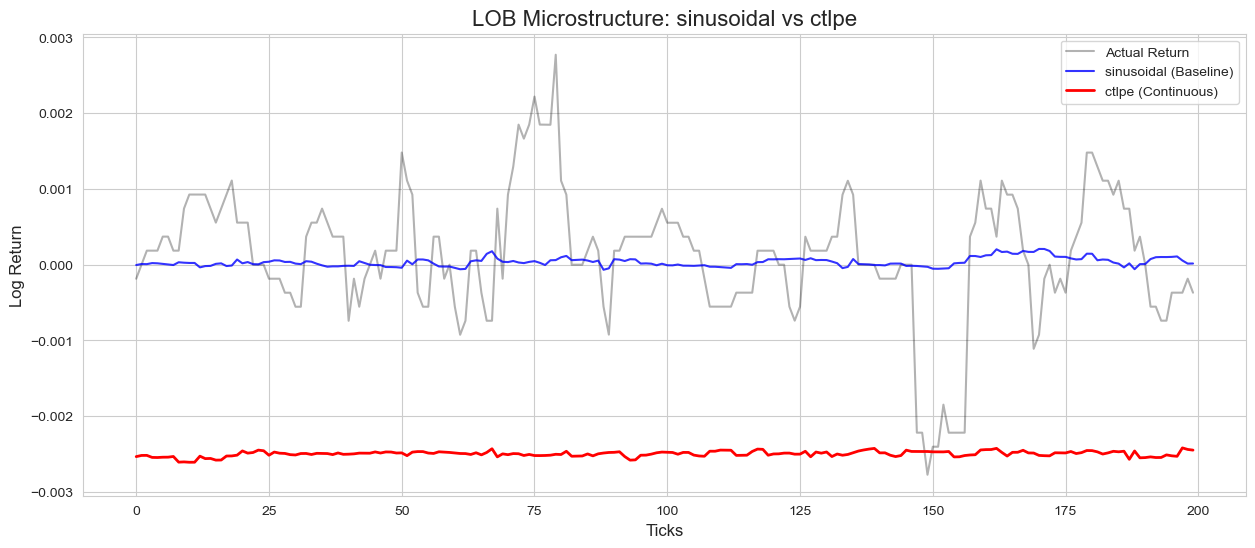

In [19]:
# Compare Two Models (e.g. Baseline vs Continuous)
m1 = "sinusoidal"
m2 = "ctlpe"  # Or time2vec

if m1 in lob_data and m2 in lob_data:
    # Pick a random 200-tick window
    start_idx = 1000 
    end_idx = 1200
    
    actual = lob_data[m1].iloc[start_idx:end_idx]['actual'].values
    pred1 = lob_data[m1].iloc[start_idx:end_idx]['predicted'].values
    pred2 = lob_data[m2].iloc[start_idx:end_idx]['predicted'].values
    
    plt.figure(figsize=(15, 6))
    plt.plot(actual, label='Actual Return', color='black', alpha=0.3)
    plt.plot(pred1, label=f'{m1} (Baseline)', color='blue', alpha=0.8)
    plt.plot(pred2, label=f'{m2} (Continuous)', color='red', linewidth=2)
    
    plt.title(f"LOB Microstructure: {m1} vs {m2}", fontsize=16)
    plt.ylabel("Log Return")
    plt.xlabel("Ticks")
    plt.legend()
    plt.show()

Signal Thresholds: Buy > -0.002250 | Sell < -0.002592
Directional Accuracy (on active trades): 25.31%


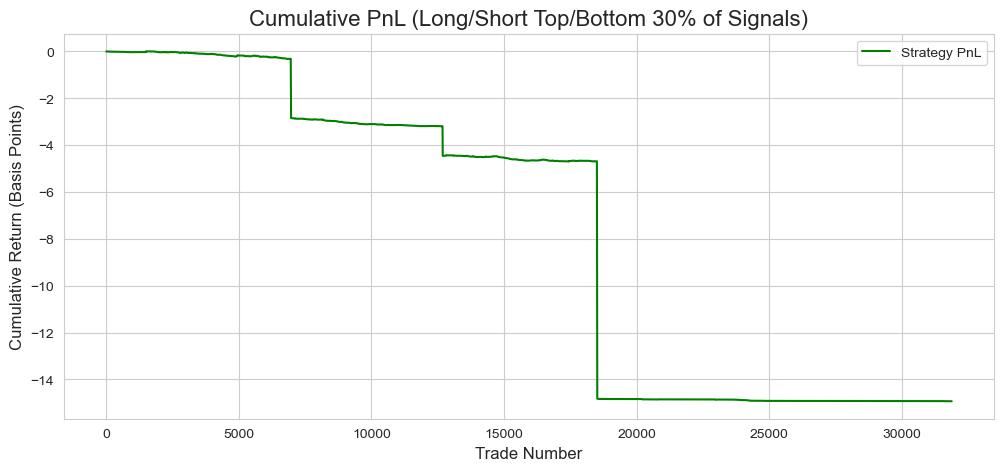

(np.float64(0.2530851286341769),
 array([ -0.       ,  -0.       ,  -0.       , ..., -14.9299477,
        -14.9299477, -14.9299477]))

In [31]:
def evaluate_signals(df, threshold_quantile=0.8):
    """
    Converts regression predictions into trading signals and evaluates performance.
    
    Args:
        df: DataFrame with 'actual' and 'predicted'
        threshold_quantile: Only trade the top/bottom (1 - quantile) predictions.
                            e.g., 0.8 means trade top 10% and bottom 10%.
    """
    pred = df['predicted'].values
    actual = df['actual'].values
    
    # 1. Determine Thresholds based on Model Confidence
    # We don't use absolute numbers (like 0.001) because the model scales are small.
    # We use percentiles.
    upper_thresh = np.percentile(pred, 100 * (1 - (1 - threshold_quantile)/2)) # Top 10%
    lower_thresh = np.percentile(pred, 100 * ((1 - threshold_quantile)/2))     # Bottom 10%
    
    print(f"Signal Thresholds: Buy > {upper_thresh:.6f} | Sell < {lower_thresh:.6f}")
    
    # 2. Generate Signals
    # 1 = Long, -1 = Short, 0 = Hold
    signals = np.zeros_like(pred)
    signals[pred > upper_thresh] = 1
    signals[pred < lower_thresh] = -1
    
    # 3. Calculate Signal Accuracy (Hit Ratio)
    # We only care about accuracy WHEN we trade (signals != 0)
    active_indices = signals != 0
    
    if np.sum(active_indices) == 0:
        print("No trades triggered!")
        return
        
    # Did the sign match?
    hits = np.sign(signals[active_indices]) == np.sign(actual[active_indices])
    hit_ratio = np.mean(hits)
    
    print(f"Directional Accuracy (on active trades): {hit_ratio:.2%}")
    
    # 4. Simple PnL Simulation (Vectorized Backtest)
    # Profit = Signal * Actual_Return
    # Note: This assumes we enter at 't' and exit at 't+horizon'. 
    # It ignores transaction costs/slippage, but is good for model comparison.
    pnl_per_trade = signals * actual
    cumulative_pnl = np.cumsum(pnl_per_trade)
    
    # Plotting
    plt.figure(figsize=(12, 5))
    plt.plot(cumulative_pnl, label='Strategy PnL', color='green')
    plt.title(f"Cumulative PnL (Long/Short Top/Bottom {100*(1-threshold_quantile):.0f}% of Signals)")
    plt.xlabel("Trade Number")
    plt.ylabel("Cumulative Return (Basis Points)")
    plt.legend()
    plt.show()
    
    return hit_ratio, cumulative_pnl


evaluate_signals(lob_data["ctlpe"], threshold_quantile=0.7)

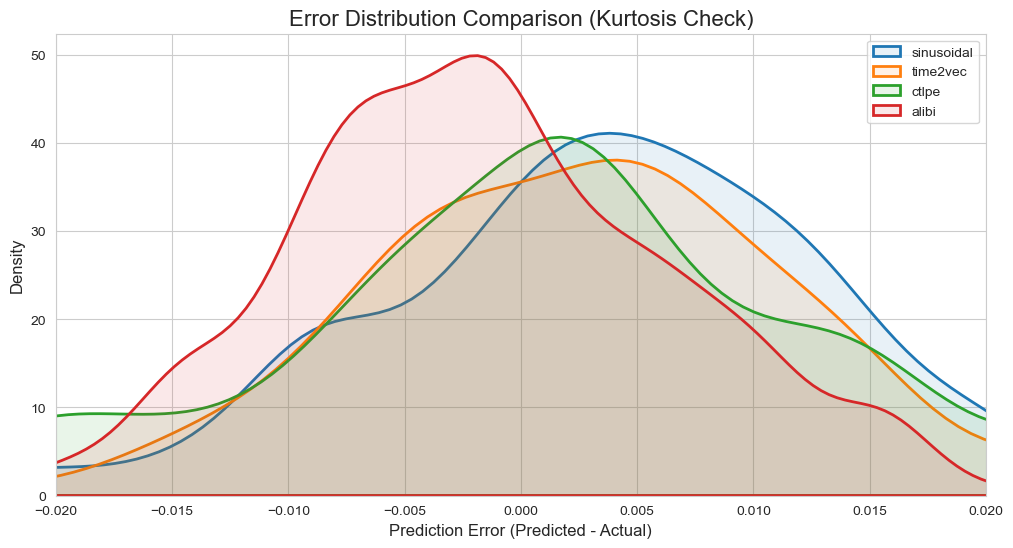

In [20]:
plt.figure(figsize=(12, 6))

# Choose which task to visualize (Daily or LOB)
data_source = daily_data # Switch to lob_data to see HFT errors

for m in MODELS:
    if m in data_source:
        error = data_source[m]['predicted'] - data_source[m]['actual']
        sns.kdeplot(error, label=m, fill=True, alpha=0.1, linewidth=2)

plt.title("Error Distribution Comparison (Kurtosis Check)", fontsize=16)
plt.xlabel("Prediction Error (Predicted - Actual)")
plt.xlim(-0.02, 0.02) # Adjust based on your data scale
plt.legend()
plt.show()